## Modeling

**Imports**

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
np.random.seed(42)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import seaborn as sns

**Reading in Data**

In [2]:
model_sets = np.load('../data/model_sets.npy')
model_sets.shape

(36003, 21)

In [3]:
#remember, I am modeling for song n + 1 based on songs n previously played:
X_rr, y_rr = model_sets[:, :-1], model_sets[:, -1] 

In [4]:
X_rr.shape, y_rr.shape

((36003, 20), (36003,))

**Train-Test Split**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_rr, y_rr, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [6]:
print(f'X_train and y_train: {X_train.shape}, {y_train.shape}')
print(f'X_test and y_test: {X_test.shape}, {y_test.shape}')

X_train and y_train: (28802, 20), (28802,)
X_test and y_test: (7201, 20), (7201,)


**Modeling - First Attempt**

In [7]:
#REVISIT
#REVISIT
#REVISIT

#consider using stringlookup instead of previously encoding:
# ids_from_chars = tf.keras.layers.StringLookup(
#     vocabulary=list(vocab), mask_token=None)

In [8]:
#https://www.tensorflow.org/text/tutorials/text_generation
songs = np.array(model_sets).tolist()
songs = [item for sublist in songs for item in sublist]

vocab = set(songs)
print(f'{len(vocab)} unique songs!')

970 unique songs!


In [9]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 970

# Number of RNN units
rnn_units = 516

In [10]:
#https://www.geeksforgeeks.org/python-keras-keras-utils-to_categorical/
#train labels:
X_train_ohe = np.array([to_categorical(x, num_classes = vocab_size) for x in X_train])
y_train_ohe = to_categorical(y_train, num_classes = vocab_size)

#test labels:
X_test_ohe = np.array([to_categorical(x, num_classes = vocab_size) for x in X_test])
y_test_ohe = to_categorical(y_test, num_classes = vocab_size)

In [11]:
print(f'Train shape: {X_train_ohe.shape}, Test shape: {X_test_ohe.shape}')
print(f'Train shape: {y_train_ohe.shape}, Test shape: {y_test_ohe.shape}')

Train shape: (28802, 20, 970), Test shape: (7201, 20, 970)
Train shape: (28802, 970), Test shape: (7201, 970)


In [12]:
#https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce
#https://www.tensorflow.org/text/tutorials/text_generation
#https://www.analyticsvidhya.com/blog/2021/08/predict-the-next-word-of-your-text-using-long-short-term-memory-lstm/
#https://stackoverflow.com/questions/55774632/gridsearchcv-randomizedsearchcv-with-lstm

model = Sequential()

#first layer, embedding:
model.add(Embedding(vocab_size, embedding_dim))

#second layer, LSTM:
model.add(LSTM(rnn_units))

#final dense layer with softmax activation:
model.add(Dense(embedding_dim, activation ='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 970)         940900    
                                                                 
 lstm (LSTM)                 (None, 516)               3069168   
                                                                 
 dense (Dense)               (None, 970)               501490    
                                                                 
Total params: 4,511,558
Trainable params: 4,511,558
Non-trainable params: 0
_________________________________________________________________


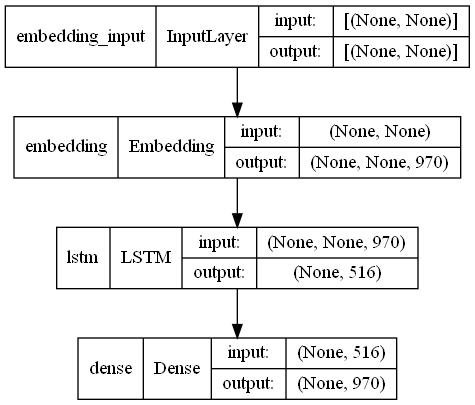

In [14]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
opt = Adam(learning_rate = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [16]:
history = model.fit(X_train, y_train_ohe,
                    validation_data = (X_test, y_test_ohe),
                    batch_size = 128, 
                    epochs = 20)

Epoch 1/20
226/226 [==============================] - 128s 544ms/step - loss: 5.0911 - accuracy: 0.0778 - val_loss: 4.7898 - val_accuracy: 0.1004
Epoch 2/20
226/226 [==============================] - 83s 368ms/step - loss: 4.6487 - accuracy: 0.1010 - val_loss: 4.8125 - val_accuracy: 0.1003
Epoch 3/20
226/226 [==============================] - 85s 378ms/step - loss: 4.5095 - accuracy: 0.1095 - val_loss: 4.9305 - val_accuracy: 0.0972
Epoch 4/20
226/226 [==============================] - 113s 501ms/step - loss: 4.3667 - accuracy: 0.1190 - val_loss: 5.0207 - val_accuracy: 0.1001
Epoch 5/20
226/226 [==============================] - 111s 493ms/step - loss: 4.2355 - accuracy: 0.1277 - val_loss: 5.1236 - val_accuracy: 0.0969
Epoch 6/20
226/226 [==============================] - 111s 490ms/step - loss: 4.1010 - accuracy: 0.1397 - val_loss: 5.2267 - val_accuracy: 0.0971
Epoch 7/20
226/226 [==============================] - 110s 489ms/step - loss: 3.9891 - accuracy: 0.1513 - val_loss: 5.3629 - v

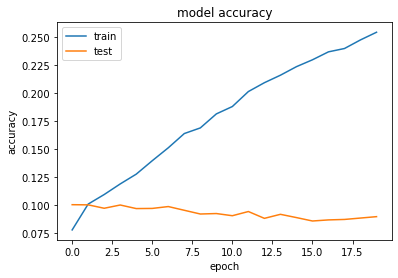

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left');

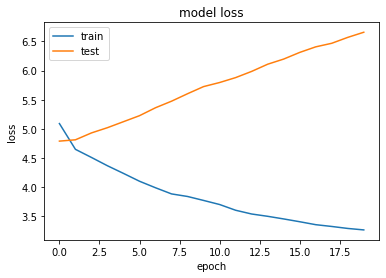

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');